# Machine Learning Challenge

## Overview

The focus of this exercise is on a field within machine learning called [Natural Language Processing](https://en.wikipedia.org/wiki/Natural-language_processing). We can think of this field as the intersection between language, and machine learning. Tasks in this field include automatic translation (Google translate), intelligent personal assistants (Siri), information extraction, and speech recognition for example.

NLP uses many of the same techniques as traditional data science, but also features a number of specialised skills and approaches. There is no expectation that you have any experience with NLP, however, to complete the challenge it will be useful to have the following skills:

- understanding of the python programming language
- understanding of basic machine learning concepts, i.e. supervised learning


### Instructions

1. Download this notebook!
2. Answer each of the provided questions, including your source code as cells in this notebook.
3. Share the results with us, e.g. a Github repo.

### Task description

You will be performing a task known as [sentiment analysis](https://en.wikipedia.org/wiki/Sentiment_analysis). Here, the goal is to predict sentiment -- the emotional intent behind a statement -- from text. For example, the sentence: "*This movie was terrible!"* has a negative sentiment, whereas "*loved this cinematic masterpiece*" has a positive sentiment.

To simplify the task, we consider sentiment binary: labels of `1` indicate a sentence has a positive sentiment, and labels of `0` indicate that the sentence has a negative sentiment.

### Dataset

The dataset is split across three files, representing three different sources -- Amazon, Yelp and IMDB. Your task is to build a sentiment analysis model using both the Yelp and IMDB data as your training-set, and test the performance of your model on the Amazon data.

Each file can be found in the `input` directory, and contains 1000 rows of data. Each row contains a sentence, a `tab` character and then a label -- `0` or `1`. 

**Notes**
- Feel free to use existing machine learning libraries as components in you solution!
- Suggested libraries: `sklearn` (for machine learning), `pandas` (for loading/processing data), `spacy` (for text processing).
- As mentioned, you are not expected to have previous experience with this exact task. You are free to refer to external tutorials/resources to assist you. However, you will be asked to justfify the choices you have made -- so make you understand the approach you have taken.

In [1]:
import os
print(os.listdir("./input"))

['amazon_cells_labelled.txt', 'yelp_labelled.txt', 'imdb_labelled.txt']


In [2]:
!head "./input/amazon_cells_labelled.txt"

So there is no way for me to plug it in here in the US unless I go by a converter.	0
Good case, Excellent value.	1
Great for the jawbone.	1
Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!	0
The mic is great.	1
I have to jiggle the plug to get it to line up right to get decent volume.	0
If you have several dozen or several hundred contacts, then imagine the fun of sending each of them one by one.	0
If you are Razr owner...you must have this!	1
Needless to say, I wasted my money.	0
What a waste of money and time!.	0


# Tasks
### 1. Read and concatenate data into test and train sets.
### 2. Prepare the data for input into your model.

**install libraries**

```shell
!pip install spacy
!python -m spacy download en_core_web_sm
!python -m spacy download en_core_web_lg
!pip install nltk
!pip install sklearn
!pip install seaborn
```

In [3]:
import json
import spacy
from spacy.tokens.token import Token
from nltk import ngrams
from dataclasses import dataclass
from typing import List, Dict, Union

In [4]:
nlp = spacy.load("en_core_web_lg")

In [5]:
@dataclass
class Sentence:
    sentence: str
    label: int
    tokens: List[Token]

In [6]:
def parse_line(line: str):
    sentence, label = line.strip().split('\t')
    label = int(label)
    tokens = nlp(sentence)
    return Sentence(sentence, label, tokens)


def load_sentiment_data(*files: str):
    data = (
        parse_line(line)
        for f in files 
        for line in open(f, 'r')
    )
    return data

**Load train set and test set, for only 1000 records in each file, just load to memory**

In [7]:
train_set = list(load_sentiment_data('input/imdb_labelled.txt', 'input/yelp_labelled.txt'))
test_set = list(load_sentiment_data('input/amazon_cells_labelled.txt'))

*To get all tag of spacy*

for label in nlp.get_pipe("tagger").labels:
    print(label, " -- ", spacy.explain(label))
    
*To get all dep of spacy*

for label in nlp.get_pipe("parser").labels:
    print(label, " -- ", spacy.explain(label))

#### 2a: Find the ten most frequent words in the training set.

*Wordcount by tag and dep, and then show top 20 for each of the dep/tag*

In [8]:
def wordcount(dataset):
    tag_counter = {}
    dep_counter = {}
    text_counter = {}

    for row in dataset:
        for token in row.tokens:
            text = token.text.lower()
            dep = token.dep_
            tag = token.tag_
            lemma = token.lemma_
            tag_counter.setdefault(tag, {})[lemma] = tag_counter.get(tag, {}).get(lemma, 0) + 1
            dep_counter.setdefault(dep, {})[lemma] = dep_counter.get(dep, {}).get(lemma, 0) + 1
            text_counter[text] = text_counter.get(text, 0) + 1
    
    return tag_counter, dep_counter, text_counter

In [9]:
wordcount_tag, wordcount_dep, wordcount_text = wordcount(train_set)

In [10]:
print('Top 20 most frequent words:')
sorted(wordcount_text.items(), key=lambda x: x[1], reverse=True)[:20]

Top 20 most frequent words:


[('.', 1731),
 ('the', 1432),
 (',', 1012),
 (' ', 1000),
 ('and', 826),
 ('a', 669),
 ('i', 659),
 ('is', 517),
 ('of', 504),
 ('was', 501),
 ('it', 476),
 ('to', 473),
 ('this', 434),
 ('!', 333),
 ('in', 312),
 ('that', 235),
 ('for', 215),
 ("'s", 200),
 ("n't", 199),
 ('not', 193)]

#**Print wordcount for each of the tag and dep**

```python
print('Top frequent words for each tag_:')
for tag, counts in wordcount_tag.items():
    print(tag, '>>', sorted(counts.items(), key=lambda x: -x[1])[:40])
```

```python
print('Top frequent words for each dep_:')
for dep, counts in wordcount_dep.items():
    print(dep, '>>', sorted(counts.items(), key=lambda x: -x[1])[:40])
```

In [11]:
# Review the tags, deps manually and select following tags and deps, and stopwords
# tags and deps not in the follwoing whitelist won't be considered, e.g. most Noun and Verb won't be considered

all_tags = {
    'RB', 'VBG', 'JJ', 'IN', 'WP', 'VBD', 'RBR', 'VBN', 'RP', 'VB', 'JJS', 'WRB', 'VBZ', 'WDT', 
    'VBP', 'MD', 'RBS', 'JJR', 'UH', 'EX', 'PDT', 'DT', 'CC'
}

all_deps = {'det', 'advmod', 'amod', 'ROOT', 'prep', 'neg', 'ccomp', 'acomp', 'attr', 'cc', 'conj', 
            'prt', 'mark', 'dep', 'aux', 'relcl', 'acl', 'intj', 'preconj', 'predet', 'csubj', 'pcomp', 'oprd'}

stopwords = {
    '-', 'be', 'the', 'and', 'of', 'a', 'have', 'in', 'this', 
    'for', 'that', 'do', 'with', 'to', 'as', 'on', 'at', 'by', 
    'from', 'about', 'an', 'here', 'movie', 'film', 'food', 'place',
    'service', 'eat', 'restaurant', '&', 'music', 'pizza', 'lunch', ' ',
    'shrimp-', 'so', 'go', 'there', 'which', 'who', 'or'
}

### 3. Train your model and justify your choices.

#### 3a: Generate features, use single word and n-gram in the above `all_tags`/`all_deps` list and `stopwords`

In [12]:
def as_feature(tokens: List[Token]):
    feature = []
    for tok in tokens:
        if (tok.lemma_ not in stopwords and (tok.tag_ in all_tags or tok.dep_ in all_deps)):
            feature.append(tok.lemma_)
    if feature:
        return ';;'.join(sorted(feature))
    return None


def feature_generator(n_gram):
    def generate_features(tokens: List[Token]):
        features = set()
        for i in range(1, n_gram+1):
            for words in ngrams(tokens, i):
                feature = as_feature(words)
                if feature is not None:
                    features.add(feature)
        return features
    
    return generate_features

@dataclass
class FeatureAttr:
    value: str
    count: int
    index: int

def generate_feature_lookup(dataset, feature_generator_func) -> Dict[str, FeatureAttr]:
    """
    feature_generator_func: n-gram feature generation function, calling `feature_generator` 
    with n_gram to generate the generator functions with n-gram features.
    
    Generate FeatureAttr
    """
    feature_dict = {}
    for row in dataset:
        for feature in feature_generator_func(row.tokens):
            feature_dict[feature] = feature_dict.get(feature, 0) + 1
            
    lookup_dict = {}
    for index, kv in enumerate(feature_dict.items()):
        key = kv[0]
        value = kv[1]
        lookup_dict[key] = FeatureAttr(key, value, index)
        
    return lookup_dict

##### Generate n-dimension traning vector

In [13]:
def features2vector(tokens: List[Token], feature_lookup: Dict[str, FeatureAttr], feature_generator_func, by_count=False):
    num_features = len(feature_lookup)
    row_array = [0 for _ in range(num_features)]
    for feature in feature_generator_func(tokens):
        if feature in feature_lookup:
            if by_count:
                # use the occurance of the token in this document as the feature
                row_array[feature_lookup[feature].index] += 1
            else:
                row_array[feature_lookup[feature].index] = 1
    return row_array

In [14]:
def to_X(dataset, feature_lookup, feature_generator_func, by_count=False):
    return [
        features2vector(row.tokens, feature_lookup, feature_generator_func, by_count)
        for row in dataset
    ]

def to_y(dataset):
    return [row.label for row in dataset]

In [15]:
from sklearn import metrics
import seaborn
from matplotlib import pyplot as plt

In [16]:
def evaluate_model(y_label, y_predict):
    conf_matrix = metrics.confusion_matrix(y_label, y_predict)
    
    print('Confusion Matrix:\n', conf_matrix)
    seaborn.heatmap(conf_matrix, annot=True, fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('Labeled')
    
    print('Accuracy:', metrics.accuracy_score(y_label, y_predict))
    print('Precision:', metrics.precision_score(y_label, y_predict))
    print('Recall:', metrics.recall_score(y_label, y_predict))

In [17]:
@dataclass
class PreparedData:
    feature_lookup: Dict[str, FeatureAttr]
    X_train: List[List[Union[int, float]]]
    y_train: List[Union[int, float]]
    X_test: List[List[Union[int, float]]]
    y_test: List[Union[int, float]]

In [18]:
def generate_all_datasets(dataset_train, dataset_test, n_gram, by_count):
    """
    Generate all required datasets for traning and evaluation for given parameters:
        - feature_lookup containing map of feature and idnex, and map of feature and its wordcount (for all sample data)
        - train X, y
        - test X, y
    """
    
    print(f'n-gram is {n_gram}')

    feature_generator_func = feature_generator(n_gram)
    feature_lookup = generate_feature_lookup(dataset_train, feature_generator_func)

    X_train = to_X(dataset_train, feature_lookup, feature_generator_func=feature_generator_func, by_count=by_count)
    y_train = to_y(dataset_train)
    
    X_test = to_X(dataset_test, feature_lookup, feature_generator_func=feature_generator_func, by_count=by_count)
    y_test = to_y(dataset_test)
    
    return PreparedData(
        feature_lookup=feature_lookup,
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test
    )

In [19]:
def print_feature_vector(sentence, vector, feature_lookup):
    feature_view = [(x[0][0], x[1]) for x in 
                  zip(
                      sorted(feature_lookup.items(), key=lambda x: x[1].index),
                      vector
                  ) 
                  if x[1] != 0]
    print('original comment:', sentence)
    print('features of the first sample:', feature_view)
    

def print_feature(row: Sentence, feature_lookup: Dict[str, FeatureAttr], feature_generator_func, by_count):
    vector = features2vector(row.tokens, feature_lookup, feature_generator_func, by_count)
    print_feature_vector(row.sentence, vector, feature_lookup)
    
def print_feature_by_X(dataset, X, k, feature_lookup):
    print_feature_vector(dataset[k].sentence, X[k], feature_lookup)

#### Generate features with n-gram is 5

In [20]:
prepared_data = generate_all_datasets(train_set, test_set, 5, False)

n-gram is 5


In [21]:
print_feature(train_set[2], prepared_data.feature_lookup, feature_generator(4), False)

original comment: Attempting artiness with black & white and clever camera angles, the movie disappointed - became even more ridiculous - as the acting was poor and the plot and lines almost non-existent.  
features of the first sample: [('more', 1), ('attempt', 1), ('almost;;non', 1), ('poor', 1), ('ridiculous', 1), ('more;;ridiculous', 1), ('almost;;line;;non', 1), ('existent;;non', 1), ('become;;even;;more', 1), ('attempt;;black', 1), ('even', 1), ('become;;disappoint;;even', 1), ('clever;;white', 1), ('even;;more', 1), ('line;;plot', 1), ('non', 1), ('become;;even;;more;;ridiculous', 1), ('plot', 1), ('plot;;poor', 1), ('become;;disappoint', 1), ('even;;more;;ridiculous', 1), ('almost;;line;;plot', 1), ('clever', 1), ('almost;;line', 1), ('become', 1), ('existent', 1), ('white', 1), ('disappoint', 1), ('line', 1), ('almost', 1), ('become;;even', 1), ('almost;;existent;;non', 1), ('black;;white', 1), ('black', 1)]


**A view of the features**

In [22]:
feature_dict_desc = [(x[0], x[1].count) for x in sorted(prepared_data.feature_lookup.items(), key=lambda x: -x[1].count)]
print('Top 20:', feature_dict_desc[:20], '\n\nMid:', feature_dict_desc[2200:2240], '\n\nLast 20:', feature_dict_desc[-20:])
print(f'Feature dimension with n-gram (n is [1, 5]):', len(feature_dict_desc))

Top 20: [('good', 189), ("n't", 188), ('not', 184), ('but', 154), ('very', 128), ('bad', 111), ('great', 104), ('like', 103), ('all', 98), ('just', 97), ('see', 85), ('well', 80), ('make', 78), ('really', 74), ('if', 73), ('get', 67), ('out', 66), ('back', 65), ('even', 59), ('would', 59)] 

Mid: [('along;;very;;well', 1), ('joy;;real', 1), ('along;;help;;very', 1), ('could;;play;;well', 1), ('along;;very', 1), ('idiot', 1), ('maybe;;well', 1), ('idiot;;maybe', 1), ('along;;help', 1), ('could;;play', 1), ('along;;maybe;;very;;well', 1), ('idiot;;maybe;;well', 1), ('could;;idiot', 1), ('maybe;;very;;well', 1), ("cinematography;;n't;;quite", 1), ("cinematography;;n't", 1), ("n't;;quite", 1), ("good;;n't;;quite", 1), ('boring;;sometimes', 1), ('find;;sometimes', 1), ('occupy;;peak', 1), ('find;;occupy;;sometimes', 1), ('happen;;never;;watch', 1), ('during;;happen', 1), ('instead;;never;;watch', 1), ('find;;occupy', 1), ('never;;watch', 1), ('instead;;peak', 1), ('peak', 1), ('find;;occupy

##### Train a model with LogisticRegression (solver=lbfgs) algorithm

In [23]:
from sklearn.linear_model import LogisticRegression

In [24]:
def save_lr_model(lr_model, feature_lookup, path):
    model = {
        'intercept': lr_model.intercept_[0],
        'coefficients': list(zip(map(lambda x: x[0], sorted(feature_lookup.items(), key=lambda x: x[1].index)), lr_model.coef_.tolist()[0]))
    }
    json.dump(model, open(path, 'w'), indent=2)

In [25]:
def train_lr_model(X, y):
    model = LogisticRegression(solver='lbfgs').fit(X, y)
    print('Train set avg accuracy:', model.score(X, y))

    return model

In [26]:
clf_lr = train_lr_model(prepared_data.X_train, prepared_data.y_train)

Train set avg accuracy: 0.992


##### save the model's coefficients/intercept for manual review

In [27]:
save_lr_model(clf_lr, prepared_data.feature_lookup, 'model_lr.json')

### 4. Evaluate your model using metric(s) you see fit and justify your choices.

Confusion Matrix:
 [[362 138]
 [ 97 403]]
Accuracy: 0.765
Precision: 0.744916820702403
Recall: 0.806


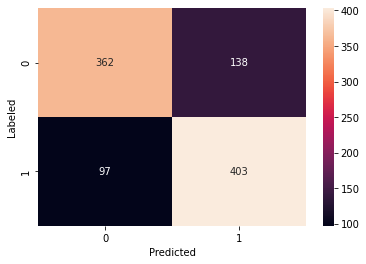

In [28]:
y_predict = clf_lr.predict(prepared_data.X_test)
evaluate_model(prepared_data.y_test, y_predict)

### 5. Try to improve

##### 5a. adjust the train and test dataset

The above train set is more about file/move, it might be a skewed dataset. Try to re-split the dataset as 80%/20%.

In [29]:
train_set_sh = train_set[:800] + train_set[1000:1800] + test_set[:800]
test_set_sh = train_set[800:1000] + train_set[1800:] + test_set[800:]

In [30]:
print(f'Re-split the train/test set as 80%/20%: {len(train_set_sh)}/{len(test_set_sh)}')

Re-split the train/test set as 80%/20%: 2400/600


In [31]:
prepared_data_sh = generate_all_datasets(train_set_sh, test_set_sh, 5, False)

n-gram is 5


In [32]:
clf_lr_sh = train_lr_model(prepared_data_sh.X_train, prepared_data_sh.y_train)

Train set avg accuracy: 0.9895833333333334


Confusion Matrix:
 [[298  49]
 [ 55 198]]
Accuracy: 0.8266666666666667
Precision: 0.8016194331983806
Recall: 0.782608695652174


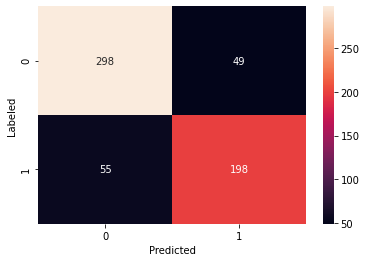

In [33]:
y_predict_sh = clf_lr_sh.predict(prepared_data_sh.X_test)
evaluate_model(prepared_data_sh.y_test, y_predict_sh)

##### 5b try random forest

In [34]:
from sklearn.ensemble import RandomForestClassifier

In [35]:
clf_rf = RandomForestClassifier(n_estimators=300)
clf_rf.fit(prepared_data.X_train, prepared_data.y_train)

RandomForestClassifier(n_estimators=300)

In [36]:
clf_rf.score(prepared_data.X_train, prepared_data.y_train)

0.9995

Confusion Matrix:
 [[326 174]
 [ 74 426]]
Accuracy: 0.752
Precision: 0.71
Recall: 0.852


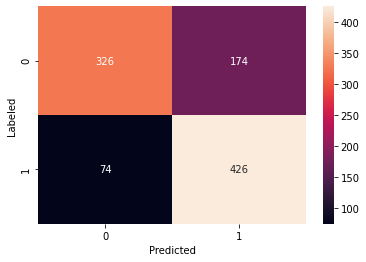

In [37]:
y_predict_rf = clf_rf.predict(prepared_data.X_test)
evaluate_model(prepared_data.y_test, y_predict_rf)

## Manual check (for the first Logistic Regression Model)

In [38]:
wrong_predictions = list(filter(lambda x: x[1][0] != x[1][1], enumerate(zip(y_predict, prepared_data.y_test))))

In [39]:
wrong_predictions[:10]

[(3, (1, 0)),
 (5, (1, 0)),
 (22, (1, 0)),
 (23, (0, 1)),
 (30, (1, 0)),
 (32, (1, 0)),
 (39, (1, 0)),
 (46, (1, 0)),
 (47, (1, 0)),
 (49, (1, 0))]

In [40]:
for index, (predict, lable) in wrong_predictions[:20]:
    print('-' * 20)
    print(f'Predict: {predict}, label: {lable}, predict_score: {clf_lr.predict_proba([prepared_data.X_test[index]])}')
    print_feature_by_X(test_set, prepared_data.X_test, index, prepared_data.feature_lookup)
    print()

--------------------
Predict: 1, label: 0, predict_score: [[0.45697056 0.54302944]]
original comment: Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!
features of the first sample: [('more', 1), ('than', 1), ('more;;than', 1), ('last', 1), ('tie', 1), ('major', 1)]

--------------------
Predict: 1, label: 0, predict_score: [[0.34586775 0.65413225]]
original comment: I have to jiggle the plug to get it to line up right to get decent volume.
features of the first sample: [('line', 1), ('right', 1), ('up', 1), ('decent', 1), ('get', 1), ('get;;right;;up', 1), ('get;;right', 1)]

--------------------
Predict: 1, label: 0, predict_score: [[0.3692065 0.6307935]]
original comment: The commercials are the most misleading.
features of the first sample: [('most', 1)]

--------------------
Predict: 0, label: 1, predict_score: [[0.57976703 0.42023297]]
original comment: I have yet to run this new battery below two bars and that's three days without charging.
features

#### ada on decision tree

In [48]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

In [49]:
clf_ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), n_estimators=100)

In [50]:
clf_ada.fit(prepared_data.X_train, prepared_data.y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                   n_estimators=100)

In [51]:
clf_ada.score(prepared_data.X_train, prepared_data.y_train)

0.9605

Confusion Matrix:
 [[326 174]
 [ 74 426]]
Accuracy: 0.752
Precision: 0.71
Recall: 0.852


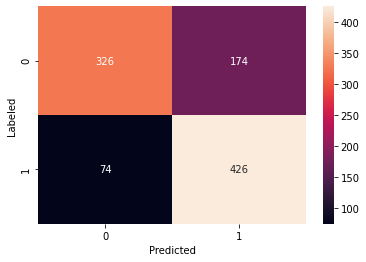

In [52]:
y_predict_ada = clf_rf.predict(prepared_data.X_test)
evaluate_model(prepared_data.y_test, y_predict_ada)

Refer to this: https://scikit-learn.org/0.15/auto_examples/model_selection/randomized_search.html

In [55]:
from scipy.stats import randint as sp_randint
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [59]:
clf_rfc = RandomForestClassifier(n_estimators=100)
# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(clf_rfc, param_distributions=param_dist, n_iter=n_iter_search)

In [60]:
random_search.fit(prepared_data.X_train, prepared_data.y_train)

RandomizedSearchCV(estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, None],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x17de44a60>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x17de44d60>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1891c2340>})

In [62]:
y_predict_rs = random_search.predict(prepared_data.X_test)

In [64]:
random_search.score(prepared_data.X_train, prepared_data.y_train)

0.9995

Confusion Matrix:
 [[326 174]
 [ 90 410]]
Accuracy: 0.736
Precision: 0.702054794520548
Recall: 0.82


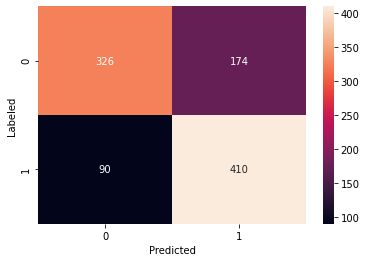

In [63]:
evaluate_model(prepared_data.y_test, y_predict_rs)